In [1]:
#loading data
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
mat = loadmat('Data/All_data_bigR.mat') 
mdata = mat['Dataset']  # variable in mat file
mdtype = mdata.dtype


df = pd.DataFrame(mdata,
                  columns = ['moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40','Z_labels']
                 )
df.loc[df['minpeaks'] >= 2, 'minpeaks'] = 2
df.loc[df['maxpeaks'] >= 2, 'maxpeaks'] = 2

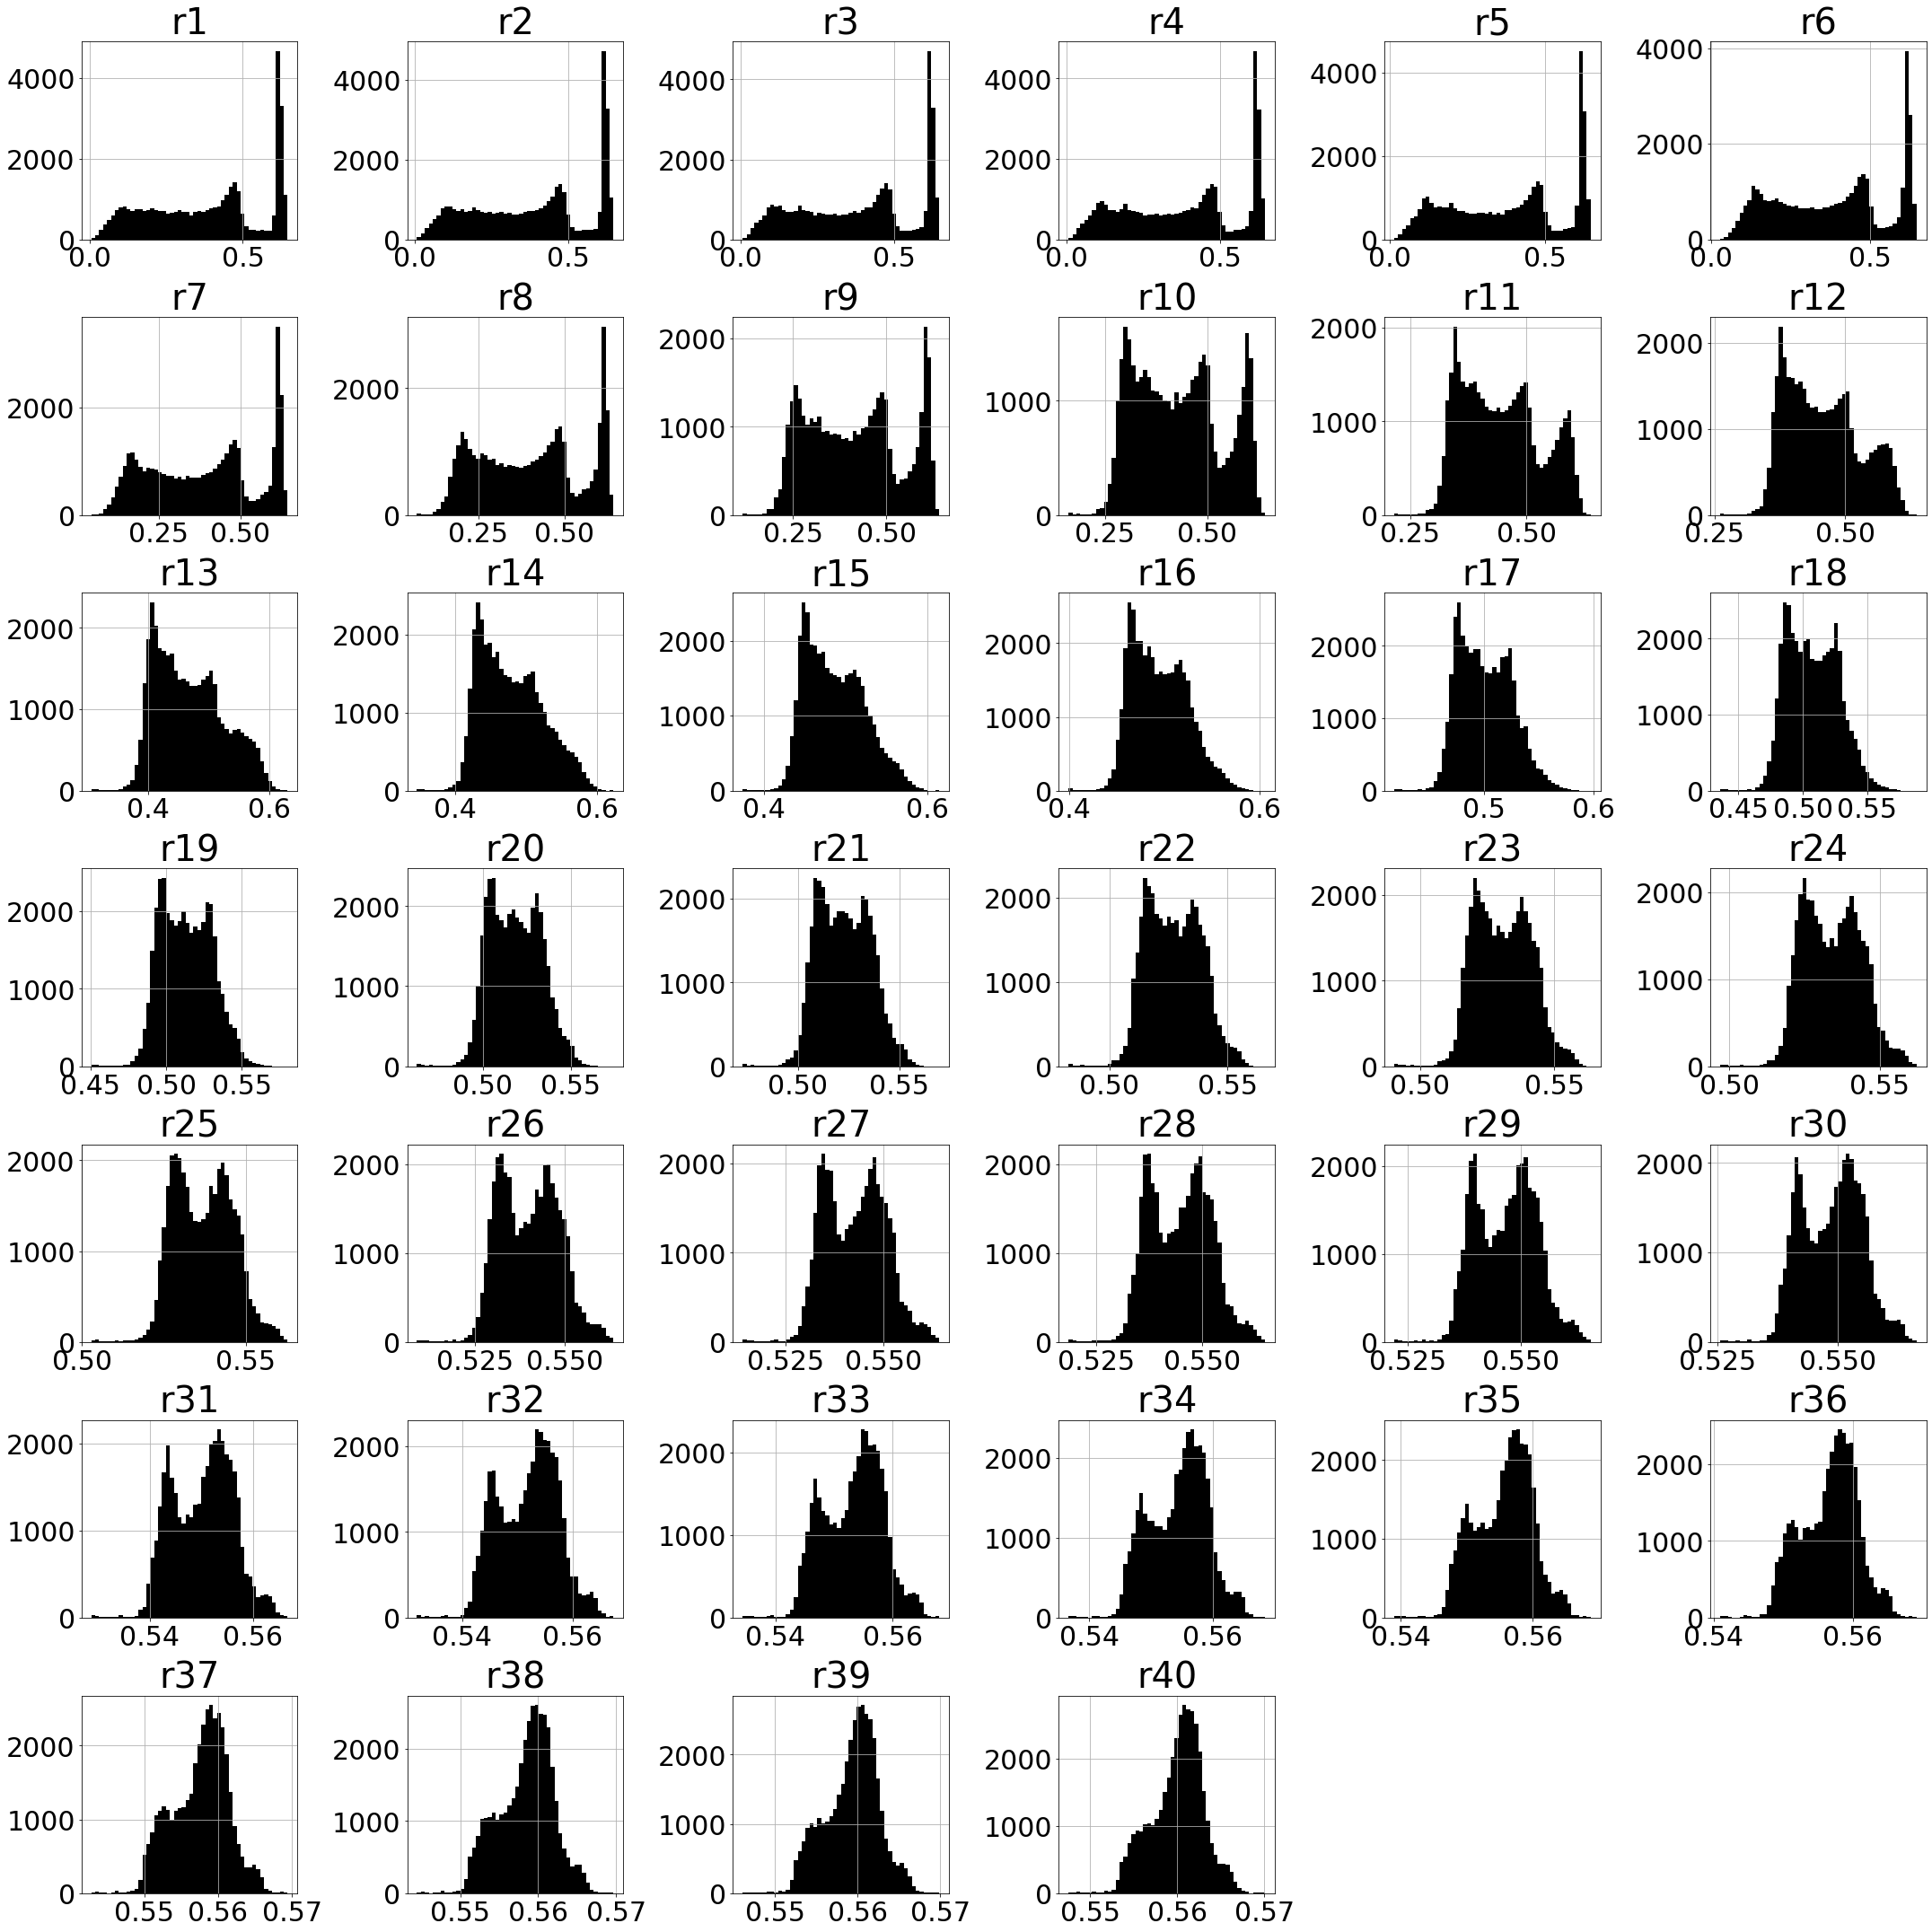

<Figure size 432x288 with 0 Axes>

In [4]:
radial_prof = ['r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']
test = df[radial_prof].copy()

import matplotlib

params = {'axes.titlesize':'40',
          'xtick.labelsize':'30',
          'ytick.labelsize':'30'}
matplotlib.rcParams.update(params)

#%matplotlib inline
import matplotlib.pyplot as plt


fig = test.hist(bins=50,figsize=(30,30), color='k')
plt.tight_layout()
# [(x.title.set_size(32)) for x in fig.ravel()]
plt.show()

# plt.savefig("Radial_profile.png", format="png", bbox_inches="tight")


In [2]:
#splitting data into train/test and processing to remove outliers in train
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Z_labels"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
dropped_labels = ["Z_labels", "sum_peaks"] #drop sum_peaks as it is noise/linear with min peaks and max peaks

#Test data
X_test = strat_test_set.drop(dropped_labels, axis=1)
Y_test = strat_test_set["Z_labels"].copy()

#Train data
train_X = strat_train_set.drop(dropped_labels, axis=1)#df_train_new.drop(dropped_labels, axis=1)
Y_train = strat_train_set["Z_labels"].copy()#df_train_new["Z_labels"].copy()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from factor_analyzer import FactorAnalyzer

#Feature engineering 

num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']    
cat_attribs = ['minpeaks','maxpeaks']

factored_num_pipeline = Pipeline([
    ("Factor_analysis", FactorAnalyzer(n_factors=9, rotation="varimax")),
])

train_X_num = train_X[num_attribs].copy()
train_X_num_processed = factored_num_pipeline.fit_transform(train_X_num)

cat_attribs = ['minpeaks','maxpeaks']
cat_encoder = OneHotEncoder(handle_unknown = "ignore")

train_X_cat = train_X[cat_attribs].copy()
train_X_OHE = cat_encoder.fit_transform(train_X_cat).toarray()
train_X_final = np.concatenate((train_X_num_processed, train_X_OHE),axis=1 )

In [4]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=200, max_features=None, max_depth = 50 ,verbose=False, random_state=42, n_jobs=-1)
extra_trees_reg.fit(train_X_final,Y_train)

#NB: did not save the pipelines etc. since did not have real data to apply to, only for demonstration

ExtraTreesRegressor(max_depth=50, max_features=None, n_estimators=200,
                    n_jobs=-1, random_state=42, verbose=False)

In [4]:
#applying pipeline to test data
X_test_num            = X_test[num_attribs].copy()
X_test_num_processed  = factored_num_pipeline.transform(X_test_num)
X_test_cat            = X_test[cat_attribs].copy()
X_test_OHE            = cat_encoder.transform(X_test_cat).toarray()
X_test_final          = np.concatenate((X_test_num_processed, X_test_OHE ),axis=1 )

In [5]:
N2 = 1.333 #refractive index water
N1 = 1 #refractive index air
RI_corr = N2/N1
Y_test = Y_test*RI_corr

Residuals without removing outliers: 0.6999344775908395 
 Residuals with outliers removed: 0.6886036556916053
num outliers: 5, % outliers: 0.0006372673973999491


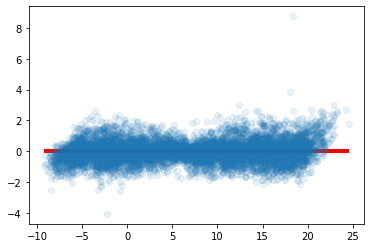

In [8]:
#fitting ERT regressor
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]

# final_predictions = extra_trees_reg.predict(X_test_final)
final_predictions = model.predict(X_test_final)*RI_corr
residuals = Y_test.to_numpy()-final_predictions

outliers = Tukey_outlier_detection(residuals, outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.to_numpy(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(final_predictions,(outliers))

In [9]:
#normalised error as defined 
np.std(residuals)/(max(Y_test)-min(Y_test))

0.020753948313603485

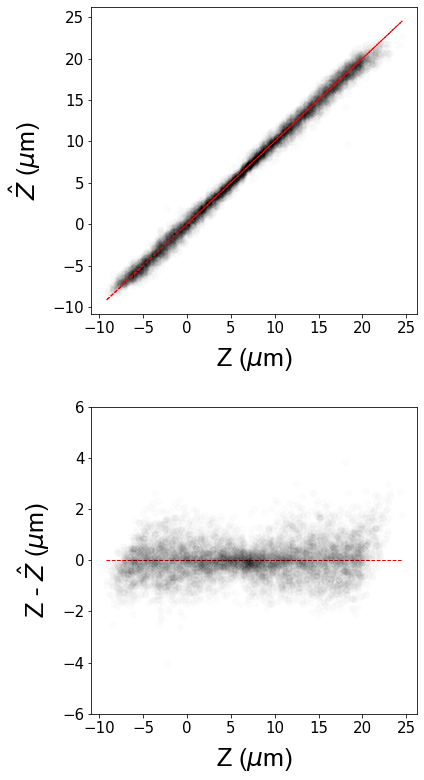

In [10]:
fig = plt.figure(figsize=(21, 13))
hfont = {'fontname':'Arial'}
# set the spacing between subplots
fig.subplots_adjust(
                    wspace=0.3, 
                    hspace=0.3)


plt.subplot(2,3,1)


plt.plot(Y_test,final_predictions,'o',color='k', alpha=0.01)
plt.plot(Y_test,Y_test,'r', linewidth=1, linestyle='--')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r"Z ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylabel(r"$\hat{Z}$ ($\mu$m)", fontsize=25, labelpad=10,**hfont)


plt.subplot(2,3,4)
plt.plot(Y_test,residuals,'o',color='k', alpha=0.01)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=1,linestyle='--')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel(r"Z ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylabel(r"Z - $\hat{Z}$ ($\mu$m)", fontsize=25, labelpad=10,**hfont)
plt.ylim([-6,6])
plt.show()
# fig.savefig("ERT_fits.pdf", format="pdf", bbox_inches="tight")

In [12]:
#save model
import joblib
joblib.dump(extra_trees_reg, "ERT_model_final.pkl")

['ERT_model_final.pkl']

In [7]:
#loading the model
import joblib
model = joblib.load("ERT_model_final.pkl")